In [44]:
# Import required libraries
from scipy import stats
from fuzzywuzzy import process
import fuzzywuzzy
import re
import pytz
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [45]:
# Read csv and use first column as index
sessions = pd.read_csv("sessions.csv", index_col=0)

In [46]:
# Print first five rows
sessions.head()

,row_id,USERID,TIMESTAMP,gender,currentRoutine,DOB,name,length,mass,dbversion,...,use_location,screenon,auto_lock,lastlogs,preloadreps,exp_level,fit_goal,audio_reminder,audio_exercise_tips,audio_personal_tips
0,### WORKOUT SESSIONS #########################...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,rowid,_id,USERID,edit_time,day_id,total_time,workout_time,rest_time,wasted_time,total_exercise,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,293965423,1,7317810,1550723647,0,80,0,0,80,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,299772744,2,7317810,1552096282,2,3022,1052,1026,314,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,299775940,3,7317810,1552093777,8,987,372,487,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# Print last five rows
sessions.tail()

,row_id,USERID,TIMESTAMP,gender,currentRoutine,DOB,name,length,mass,dbversion,...,use_location,screenon,auto_lock,lastlogs,preloadreps,exp_level,fit_goal,audio_reminder,audio_exercise_tips,audio_personal_tips
542,1258600222,541,7317810,1659970932,0,3086,901,2118,0,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
543,1264328472,542,7317810,1660406872,0,3510,1049,1947,0,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
544,1274885581,543,7317810,1661276896,0,2709,480,1580,289,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
545,1277245795,544,7317810,1661440491,107,3500,882,2182,0,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,##############################################...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
def remove_formatting(df, index_to_drop, cols_to_drop):
    
    # Drop all columns with no entries
    sessions.dropna(
        how="all", 
        axis=1, 
        inplace=True
        )

    # Rename the columns
    sessions.columns = list(
        sessions.iloc[1] # Use row at index 1 for column names
        )

    # Drop rows with no values and obsulete columns
    sessions.drop(
        index=index_to_drop, 
        columns=cols_to_drop,
        inplace=True
        )

    # Reset index
    df.reset_index(
        drop=True, 
        inplace=True
        )

    return df

In [49]:
cols = [
    "rowid", 
    "USERID", 
    "TIMESTAMP", 
    "edit_time", 
    "day_id", 
    "workout_time", 
    "rest_time", 
    "wasted_time", 
    "total_exercise", 
    "workout_mode",
    "total_weight",
    "recordbreak",
    "endtime",
] 

inds = [
    0,
    1,
    546
]

In [50]:
sessions = remove_formatting(sessions, index_to_drop=inds, cols_to_drop=cols)

In [51]:
sessions.head()

,_id,total_time,starttime
0,1,80,1550698365
1,2,3022,1552060857
2,3,987,1552063987
3,4,3749,1552145361
4,5,3728,1552239275


In [52]:
# Display datatypes of columns
sessions.dtypes

_id           object
total_time    object
starttime     object
dtype: object

In [53]:
# Convert from unix time to %Y-%m-%d format
sessions["starttime"] = pd.to_datetime(
    sessions["starttime"], 
    unit="s", # number of seconds sice 1970-1-1
    utc=True) # return timezone for easier conversion later

In [54]:
# Get current timezone using "pytz" module
cro_tz = pytz.timezone('Europe/Zagreb')

# Convert from UTC to my local timezone
sessions["starttime"] = sessions["starttime"].map(
    lambda x: x.astimezone(cro_tz))

In [55]:
# Convert total exercise time to minutes
sessions["total_time"] = sessions["total_time"].astype(int) / 60

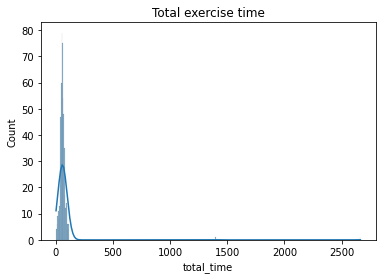

In [56]:
# Display distribution of total time exercise time
sns.histplot(
    sessions["total_time"], 
    kde=True,
    ).set(title="Total exercise time");

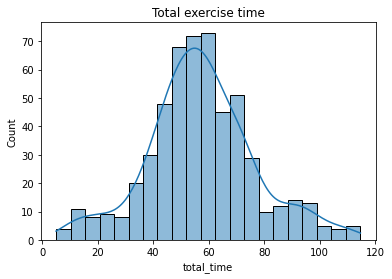

In [57]:
# Find rows with outliers and remove them
sessions.drop(index=sessions.query(
    "total_time>120 | total_time<5"
    ).index, 
    inplace=True)

# Display distribution after removing outliers
sns.histplot(
    sessions["total_time"], 
    kde=True
    ).set(title="Total exercise time");


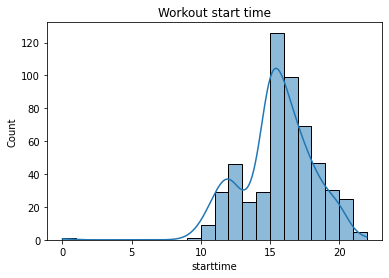

In [58]:
# Display distribution of sessions start time
sns.histplot(
    sessions["starttime"].dt.hour, 
    binwidth=1, # one bin for each hour
    kde=True
    ).set(title="Workout start time");

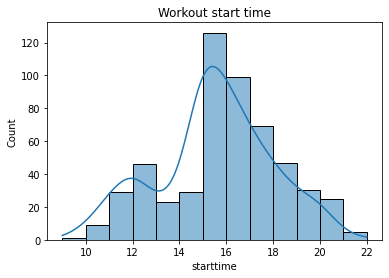

In [59]:
# Drop outliers
sessions.drop(
    index=sessions.query("~(8 < starttime.dt.hour < 23)"
    ).index, 
    inplace=True)

# Display distribution after removing outliers
sns.histplot(
    sessions["starttime"].dt.hour, 
    binwidth=1, 
    kde=True
    ).set(title="Workout start time");

In [60]:
# Reset index
sessions.reset_index(
    drop=True, # drop index column
    inplace=True)

# Save dataframe as csv file
sessions.to_csv("sessions_cleaned.csv")